In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import datasets,tree
from sklearn.tree import export_graphviz 
from sklearn import externals
from io import StringIO
import pydotplus
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt


##**1 - Business Problem**
___Use Random Forest to prepare a model on fraud data___



##**2 - Data collection and description**

In [2]:
df=pd.read_csv("/content/Fraud_check.csv")

In [3]:
df1=df.copy()

In [4]:
df1.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [5]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Taxable.Income,600.0,55208.375000,26204.827597,10003.0,32871.50,55074.5,78611.75,99619.0
City.Population,600.0,108747.368333,49850.075134,25779.0,66966.75,106493.5,150114.25,199778.0
Work.Experience,600.0,15.558333,8.842147,0.0,8.00,15.0,24.00,30.0


In [6]:
df1.isnull().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

In [7]:
df1.dtypes

Undergrad          object
Marital.Status     object
Taxable.Income      int64
City.Population     int64
Work.Experience     int64
Urban              object
dtype: object

##Outlier Check

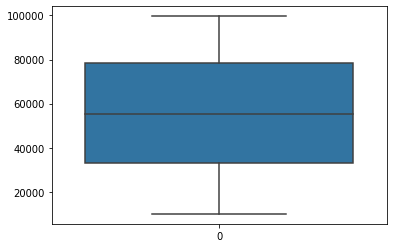

In [8]:
ax = sns.boxplot(df1['Taxable.Income'])


##There are no outliers in the data


In [9]:
plt.rcParams["figure.figsize"] = 9,5

Skew: 0.030014788906377175
Kurtosis: -1.1997824607083138


<ipython-input-10-f81e33b9586a>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(df1['Taxable.Income'],shade=True,color='g')


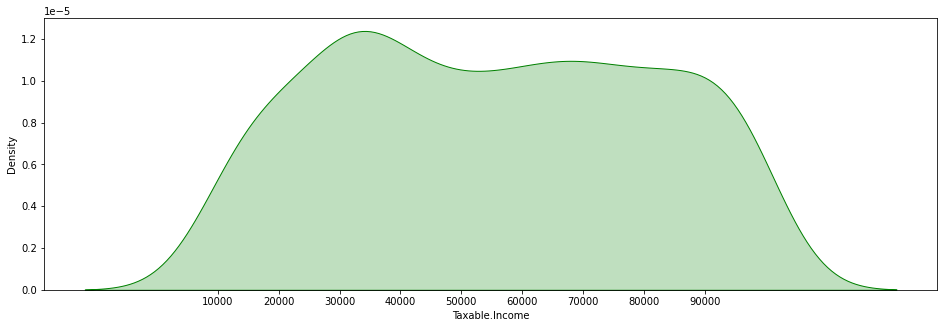

In [10]:
plt.figure(figsize=(16,5))
print("Skew: {}".format(df1['Taxable.Income'].skew()))
print("Kurtosis: {}".format(df1['Taxable.Income'].kurtosis()))
ax = sns.kdeplot(df1['Taxable.Income'],shade=True,color='g')
plt.xticks([i for i in range(10000,100000,10000)])
plt.show()

##The data is Skwed on the right
##The data has negative Kurtosis


In [11]:
obj_colum = df1.select_dtypes(include='object').columns.tolist()

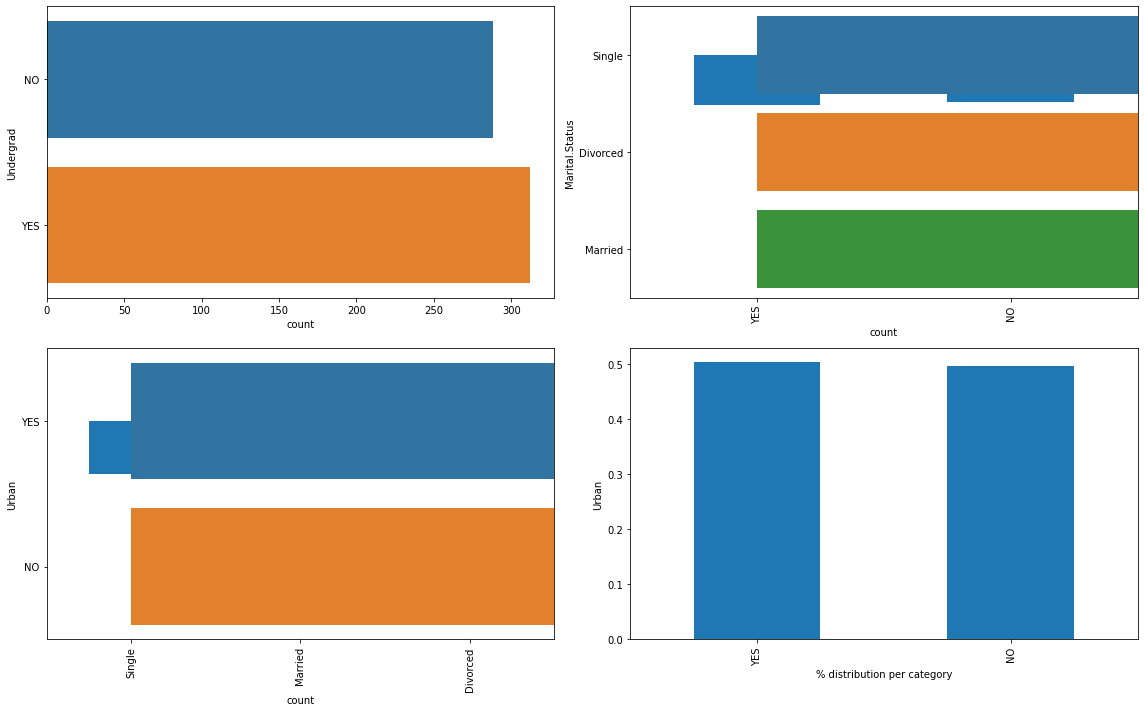

In [12]:
plt.figure(figsize=(16,10))
for i,col in enumerate(obj_colum,1):
    plt.subplot(2,2,i)
    sns.countplot(data=df1,y=col)
    plt.subplot(2,2,i+1)
    df1[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show()  

In [13]:
num_columns = df1.select_dtypes(exclude='object').columns.tolist()

<ipython-input-14-580362cfca90>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col],color='g',shade=True)
<ipython-input-14-580362cfca90>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col],color='g',shade=True)
<ipython-input-14-580362cfca90>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col],color='g',shade=True)


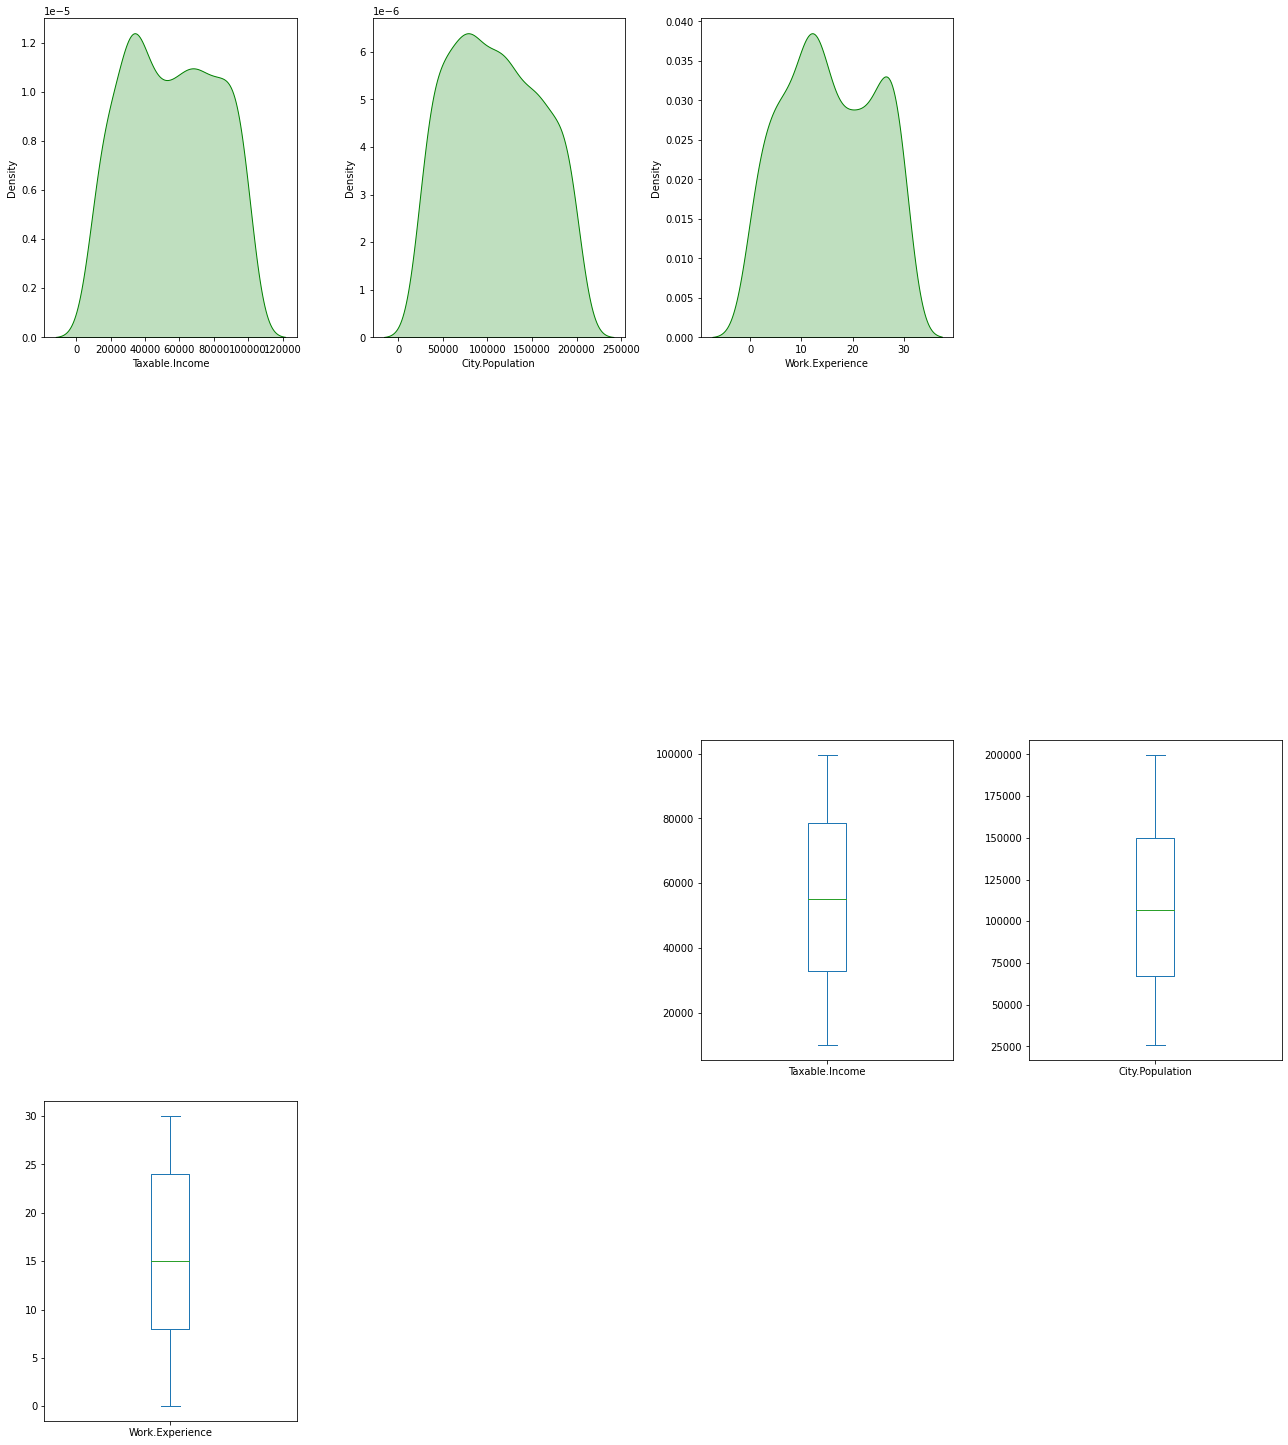

,Taxable.Income,City.Population,Work.Experience
skewness,0.030015,0.125009,0.018529
kurtosis,-1.199782,-1.120154,-1.167524


In [14]:
plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(df[col],color='g',shade=True)
    plt.subplot(8,4,i+10)
    df[col].plot.box()
plt.tight_layout() 
plt.show()
num_data = df[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

In [15]:
df1 = pd.get_dummies(df1, columns = ['Undergrad','Marital.Status','Urban'])

In [16]:
corr = df1.corr()


<Axes: >

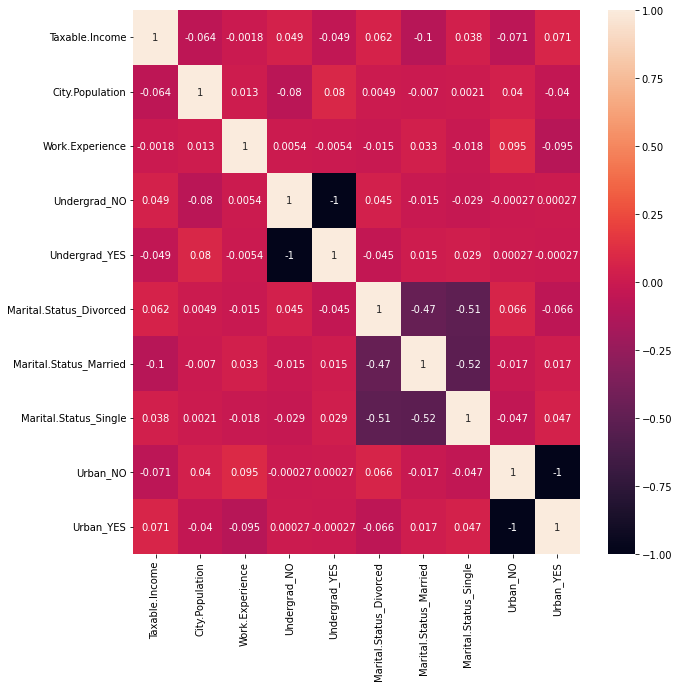

In [17]:
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True)

##**3 - Random Forest Model**

**Since the target variable is continious, we create a class of taxable_income <= 30000 as "Risky" and others are "Good"**

In [18]:
df1['Taxable.Income']=pd.cut(df1['Taxable.Income'],bins=[0,30000,100000],labels=['risky','good'])


In [19]:
list(df1.columns)

['Taxable.Income',
 'City.Population',
 'Work.Experience',
 'Undergrad_NO',
 'Undergrad_YES',
 'Marital.Status_Divorced',
 'Marital.Status_Married',
 'Marital.Status_Single',
 'Urban_NO',
 'Urban_YES']

In [20]:
X = df1.iloc[:,1:10]
y = df1.iloc[:,0]

In [21]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)


In [22]:
y_train.value_counts()

good     377
risky    103
Name: Taxable.Income, dtype: int64

In [23]:
model =RF(n_jobs=4,n_estimators = 150, oob_score =True,criterion ='entropy') 
model.fit(x_train,y_train)
model.oob_score_

0.71875

In [24]:
pred_train = model.predict(x_train)


In [25]:
accuracy_score(y_train,pred_train)


0.9979166666666667

In [26]:
confusion_matrix(y_train,pred_train)


array([[377,   0],
       [  1, 102]])

In [27]:
pred_test = model.predict(x_test)


In [28]:
accuracy_score(y_test,pred_test)


0.7833333333333333

In [29]:
confusion_matrix(y_test,pred_test)


array([[93,  6],
       [20,  1]])

In [30]:
df_t=pd.DataFrame({'Actual':y_test, 'Predicted':pred_test})


In [31]:
df_t

,Actual,Predicted
276,good,good
191,good,good
335,good,good
318,good,good
200,good,good
...,...,...
575,risky,good
275,good,good
208,good,good
73,good,good


In [32]:
cols = list(df1.columns)


In [33]:
predictors = cols[1:10]
target = cols[0]

In [34]:
tree1 = model.estimators_[20]


In [35]:
dot_data = StringIO()


In [36]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())



^
Expected {'GRAPH' | 'DIGRAPH'}  (at char 0), (line:1, col:1)


##**4 - Conclusion**

Since the accuracy of the Training set is 100% we test the accurancy on the test data which is 72%
As seen in the confusion matrix of Test data 94 instances are presdected correctly and 26 instances are not

In [42]:
rf_small = RF(n_estimators=10, max_depth = 3)


In [43]:
rf_small.fit(x_train,y_train)


RandomForestClassifier(max_depth=3, n_estimators=10)

In [44]:
tree_small = rf_small.estimators_[5]

In [45]:
export_graphviz(tree_small, out_file = dot_data, feature_names = predictors, rounded = True, precision = 1)


In [46]:
graph_small = pydotplus.graph_from_dot_data(dot_data.getvalue())


In [48]:
img = mpimg.imread('/content/fraud_small.png') 


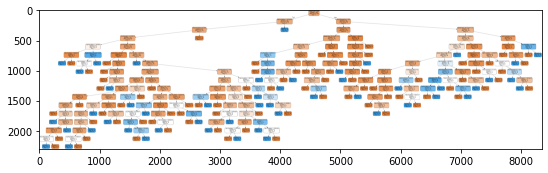

In [49]:
plt.imshow(img)


In [50]:
model.feature_importances_


array([0.51863668, 0.35505562, 0.01696371, 0.01797532, 0.01846766,
       0.02065835, 0.01984293, 0.01728078, 0.01511897])

In [51]:
fi = pd.DataFrame({'feature': list(x_train.columns),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)


In [52]:
fi

,feature,importance
0,City.Population,0.518637
1,Work.Experience,0.355056
5,Marital.Status_Married,0.020658
6,Marital.Status_Single,0.019843
4,Marital.Status_Divorced,0.018468
3,Undergrad_YES,0.017975
7,Urban_NO,0.017281
2,Undergrad_NO,0.016964
8,Urban_YES,0.015119


##**As seen in the above table city population is most important feature**